<a href="https://colab.research.google.com/github/jecampagne/ML-toys/blob/main/Test_SBI_Pytorch_ComplexExo_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version   # >= 3.7

Python 3.7.14


In [2]:
!pip install --upgrade --quiet sbi

     |████████████████████████████████| 293 kB 5.2 MB/s 
     |████████████████████████████████| 722 kB 52.0 MB/s 
     |████████████████████████████████| 45 kB 3.4 MB/s 


In [3]:
# Replace version 3.2 by 3.5
!pip uninstall -y matplotlib
!pip install -q matplotlib==3.5.0
# Needs Re-initialize the environment then pass to the next cell

Found existing installation: matplotlib 3.2.2
Uninstalling matplotlib-3.2.2:
  Successfully uninstalled matplotlib-3.2.2
     |████████████████████████████████| 11.2 MB 5.6 MB/s 
     |████████████████████████████████| 42 kB 817 kB/s 
     |████████████████████████████████| 960 kB 28.4 MB/s 


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt

print(mpl.__version__)

3.5.0


In [2]:
import torch
import numpy as np

from sbi.inference import SNPE, SNLE, SNRE, prepare_for_sbi, simulate_for_sbi
from sbi.utils.get_nn_models import posterior_nn
from sbi import utils as utils

In [3]:
# No speed up with GPU as stated in sbi code
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [4]:
import pyro
pyro.set_rng_seed(0)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
cd /content/gdrive/MyDrive/

/content/gdrive/MyDrive


In [7]:
mkdir SBIimg

mkdir: cannot create directory ‘SBIimg’: File exists


In [8]:
cd /content/gdrive/MyDrive/SBIimg

/content/gdrive/MyDrive/SBIimg


In [9]:
pwd

'/content/gdrive/MyDrive/SBIimg'

In [10]:
import arviz as az
import matplotlib.patches as mpatches

def overplot_lines(axes, xs, reverse=False, **kwargs):
    """
    Overplot lines on a figure generated by ``corner.corner``
    Parameters
    ----------
    fig : Figure
        The figure generated by a call to :func:`corner.corner`.
    xs : array_like[ndim]
       The values where the lines should be plotted. This must have ``ndim``
       entries, where ``ndim`` is compatible with the :func:`corner.corner`
       call that originally generated the figure. The entries can optionally
       be ``None`` to omit the line in that axis.
    reverse: bool
       A boolean flag that should be set to 'True' if the corner plot itself
       was plotted with 'reverse=True'.
    **kwargs
        Any remaining keyword arguments are passed to the ``ax.axvline``
        method.
    """
    K = len(xs)
    if reverse:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[K - k1 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[K - k2 - 1, K - k1 - 1].axhline(xs[k2], **kwargs)

    else:
        for k1 in range(K):
            if xs[k1] is not None:
                axes[k1, k1].axvline(xs[k1], **kwargs)
            for k2 in range(k1 + 1, K):
                if xs[k1] is not None:
                    axes[k2, k1].axvline(xs[k1], **kwargs)
                if xs[k2] is not None:
                    axes[k2, k1].axhline(xs[k2], **kwargs)

def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None, reference_values=None, 
                    reference_color='k', label_size=10,labeller=None, limits=None,
                   var_names=None, point_estimate="median", figsize=(8,8)):
    """
     limts = [[min_1,max_1], ... , [min_N, max_N]] N varaibles
    """
        
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            kind="kde",
            labeller=labeller,
            figsize=figsize,
            marginal_kwargs={"plot_kwargs": {"linewidth": 2, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidth":2},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 2, "c": "b"},
            marginals=True, textsize=label_size, point_estimate=point_estimate,
            reference_values=reference_values, reference_values_kwargs={"c":reference_color}
        );
    
    if reference_values is not None:
      overplot_lines(axs,list(reference_values.values()), color=reference_color)
      if limits is not None:
        assert len(limits) == len(samples.keys()), "wrong number of limits"
        for i in range(0,axs.shape[0]):
          for j in range(0,i+1):
            if j == i:
              axs[i,i].set_xlim(limits[i])
            else:
              axs[i,j].set_xlim(limits[j])
              axs[i,j].set_ylim(limits[i])

    plt.tight_layout()
    
    if patName is not None:
#        patName_patch = mpatches.Patch(color='b', label=patName)
#        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
      fig = axs[0,0].get_figure()
      fig.suptitle(patName)
    if fname is not None:
        plt.savefig(fname)
        plt.close()




In [11]:
#Let us define a common uniform prior for each parameter
theta_dim = 5
prior = utils.BoxUniform(low=-3 * torch.ones(theta_dim), high=3 * torch.ones(theta_dim))


In [12]:
limits = [[-3,3] for i in range(theta_dim)]

In [13]:
def _calc_vars(theta):
    """
    Calculate the mean and variance of the posterior.
    mu = theta(1, 5) * mask(5, 2) = (1, 2) vector
    s_1, s_2 = theta(n, 5) * mask(5, 2) * theta(5, n) = (n,) scalar
    rho = theta(1, 5) * mask(5, 1) = (1, 1) vector
    Sigma = [[s_1 ** 2, rho * s_1 * s_2],
            [rho * s_1 * s_2, s_2 ** 2]]
    Sigma = outer([s_1, s_2], [s_1, s_2]) * elementwise_mult rho
    """
    s_vec = torch.square(theta[2:4])
    rho = torch.tanh(theta[4])
    rho_matrix = torch.tensor([[1.,rho],[rho,1.]])

    mu = theta[:2]

    Sigma = torch.outer(s_vec, s_vec) * rho_matrix
    return mu, Sigma

import pyro.distributions as dist
def simulator(theta):
  mu, Sigma = _calc_vars(theta)
  x = dist.MultivariateNormal(mu, Sigma).sample(sample_shape=(1,4)).flatten()
  return x



In [14]:
true_theta = np.array([0.7, -2.9, -1.0, -0.9, 0.6])

In [15]:
# Let us define one observation of the following true underlaying theta param
x_o = simulator(torch.tensor(true_theta))[None]

In [16]:
x_o

tensor([[ 2.2410, -2.4301, -1.4788, -3.4594, -0.3845, -4.3274,  1.1033, -2.1519]],
       dtype=torch.float64)

In [17]:
#adapt/check the prior & simulator for SBI
simulator, prior = prepare_for_sbi(simulator, prior)

# 1 round Optimisation

In [18]:
keys = ["t"+str(i) for i in range(theta_dim)]
truth = dict(zip(keys,true_theta))


In [21]:
for name in ["SNPE","SNLE","SNRE"]:
  print("Inference :",name)
  if name == "SNPE":
    inference = SNPE(prior=prior) #"SNPE" as SNPE_C 
  elif name == "SNLE":
    inference = SNLE(prior=prior) #"SNLE" as SNLE_A 
  elif name == "SNRE":
    infer_SNRE = SNRE(prior=prior) #"SNRE" as SNRE_B

  #siumlate
  num_sim = 10_000
  theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=num_sim)
  inference = inference.append_simulations(theta, x)
  #train the inference network/flow paramater
  density_estimator = inference.train()
  #build the posterior estimate p(theta|X)
  posterior = inference.build_posterior(density_estimator)
  #Sample the posterior with the constraint x=x_o
  if isinstance(inference,SNLE) or isinstance(inference,SNRE):
    spls = posterior.sample((10_000,), x=x_o, num_chains=100,  method="slice_np_vectorized")
  else:
    spls = posterior.sample((10_000,), x=x_o)  

  #plot
  values = [spls[:,i]for i in range(theta_dim)]
  data = dict(zip(keys,values))
  plot_params_kde(data,var_names=keys, figsize=(8,8), limits=limits,
    point_estimate=None, reference_values=truth, reference_color='r',
    patName=name, fname='./complex_'+name+'_1obs_1round_limitsOn.pdf');
  

Inference : SNPE


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 105 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


Inference : SNLE


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 145 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


Inference : SNRE


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 152 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


# Multi rounds...

In [22]:
# multi rounds: first round simulates from the prior, second round simulates parameter set
# that were sampled from the obtained posterior.
num_rounds = 5
# The specific observation we want to focus the inference on is x_o (single)
num_simu = 10_000


simulator, prior = prepare_for_sbi(simulator, prior)
for name in ["SNLE","SNRE"]:
  print("Inference :",name)
  if name == "SNPE":
    inference = SNPE(prior=prior, device=device) #"SNPE" as SNPE_C 
  elif name == "SNLE":
    inference = SNLE(prior=prior, device=device) #"SNLE" as SNLE_A 
  elif name == "SNRE":
    infer_SNRE = SNRE(prior=prior, device=device) #"SNRE" as SNRE_B

  posteriors = []
  proposal = prior

  for i in range(num_rounds):
    if i==0:
      theta, x = simulate_for_sbi(simulator, proposal, num_simulations=num_simu)
    else:
      if isinstance(inference,SNPE):
        theta = proposal.sample((num_simu,))
      else:
        theta = proposal.sample((num_simu,), method="slice_np_vectorized", num_chains=100)
      x = simulator(theta)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    if isinstance(inference,SNPE):
      density_estimator = inference.append_simulations(
          theta, x, proposal=proposal
      ).train()
    else:
      density_estimator = inference.append_simulations(
          theta, x
      ).train()

    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)  
    proposal = posterior.set_default_x(x_o)

  # sample with tuned posterior
  if isinstance(inference,SNLE) or isinstance(inference,SNRE):
      spls = posterior.sample((10_000,), x=x_o, num_chains=100,  method="slice_np_vectorized")
  else:
      spls = posterior.sample((10_000,), x=x_o, method='mcmc')  


  values = [spls[:,i]for i in range(theta_dim)]
  data = dict(zip(keys,values))
  np.save("./complex_"+name+"_data.npy",np.array(values))

  plot_params_kde(data,var_names=keys, figsize=(8,8), limits=None,
      point_estimate=None, reference_values=truth, reference_color='r',
      patName=name, fname='./complex_'+name+'_1obs_'+str(num_rounds)+'rounds_limitsOn.pdf');


Inference : SNLE


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 285 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 23 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 49 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 21 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 32 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'li

Inference : SNRE


Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

 Neural network successfully converged after 47 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 30 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 28 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 29 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

 Neural network successfully converged after 39 epochs.

Running vectorized MCMC with 100 chains:   0%|          | 0/110000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'li

# Direct True Likelihood  sampling

In [47]:
def wrapper_log_posterior(theta):

    theta = theta['t']
    mu, Sigma = _calc_vars(theta)
    dist = torch.distributions.MultivariateNormal(mu, Sigma)

    log_post = dist.log_prob(x_o.reshape((4,2))).sum() + prior.log_prob(theta).sum()
    return -log_post


In [53]:
kernel = pyro.infer.NUTS(
    potential_fn=wrapper_log_posterior,jit_compile=True
)


In [54]:
import itertools

# find all combinaisons of theta_dim numbers taken in {-1,1}
lst = np.array(list(itertools.product([-1, 1], repeat=theta_dim)))
num_chains = len(lst)
# On init 1 chain par combinaison de +/- true_theta_i + random noise => 32 chaines
init_theta = [true_theta * row for i, row in enumerate(lst)]
init_theta = torch.tensor(np.stack(init_theta))
init_theta = init_theta + 0.1 * torch.randn_like(init_theta)
print(init_theta.shape)

torch.Size([32, 5])


In [58]:
mcmc = pyro.infer.MCMC(
        kernel,
        num_samples=500,
        warmup_steps=500,
        num_chains=num_chains,
        initial_params={'t': init_theta}
)


In [59]:
mcmc.run()

Warmup:   0%|          | 0/1000 [00:00, ?it/s]

KeyboardInterrupt: ignored

In [61]:
! pip install -q numpyro

     |████████████████████████████████| 292 kB 5.2 MB/s 


In [62]:
import jax
import jax.numpy as jnp
import numpyro

In [80]:
seed = 1234
rng, model_rng, hmc_rng = jax.random.split(jax.random.PRNGKey(seed), num=3)

In [63]:
j_xo = jnp.array(x_o.numpy())

In [64]:
j_xo

DeviceArray([[ 2.2409961 , -2.430144  , -1.4787893 , -3.4594    ,
              -0.38452235, -4.327405  ,  1.1033468 , -2.1519368 ]],            dtype=float32)

In [153]:
def SmoothedBoxPrior(theta_dim=5, lower=0.0, upper=1.0, sigma=0.1, variance=False):
    assert jnp.all(lower < upper), "lower must be less than upper"
    assert jnp.all(sigma > 0), "sigma must be greater than zero"
    assert jnp.logical_xor(sigma, variance), "specify only one of sigma and variance"

    if not variance:
        variance = sigma ** 2
    _center = (upper + lower) / 2.0
    _range = (upper - lower) / 2.0

    def log_prob(theta):
        """Inspired by SmoothedBoxPrior From GPyTorch
        If theta is inside the bounds, return constant.
        If theta is outside the bounds, return log prob from sharp normal
        Can accomplish this saying the distance from the edges of the theta range
        is sampled from a normal distribution (clipped at zero to not go negative)
        """
        _theta_dist = jnp.clip(jnp.abs(theta - _center) - _range, 0, None)
        return -0.5 * (_theta_dist ** 2 / variance + jnp.log(2 * jnp.pi * variance))

    def sample(rng, num_samples: int = 1):
        """
        Samples are taken from a hard uniform distribution between the bounds
        """
        return jax.random.uniform(
            rng, shape=(num_samples, theta_dim), minval=lower, maxval=upper
        )

    return log_prob, sample

In [154]:
# set up prior
log_prior, sample_prior = SmoothedBoxPrior(
    theta_dim=theta_dim, lower=-3.0, upper=3.0, sigma=0.02
)


In [155]:
def _jax_calc_vars(theta: jnp.array):
    s_vec = jnp.square(theta[2:4])
    rho = jnp.tanh(theta[4])
    rho_matrix = jnp.eye(2) + rho * jnp.eye(2)[::-1] # jnp.array([[1.,rho],[rho,1.]])

    mu = theta[:2]
    Sigma = jnp.outer(s_vec, s_vec) * rho_matrix
    return mu, Sigma

In [156]:
_jax_calc_vars(jnp.array(true_theta))

(DeviceArray([ 0.7, -2.9], dtype=float32),
 DeviceArray([[1.        , 0.43501014],
              [0.43501014, 0.6560999 ]], dtype=float32))

In [157]:
j_xo

DeviceArray([[ 2.2409961 , -2.430144  , -1.4787893 , -3.4594    ,
              -0.38452235, -4.327405  ,  1.1033468 , -2.1519368 ]],            dtype=float32)

In [158]:
def jax_log_likelihood(x: jnp.array, theta: jnp.array):
    """
    Calculate the log likelihood of the data given the posterior.
    """
    mu, Sigma = _jax_calc_vars(theta)

    x = x.reshape((4, 2))
    return jax.scipy.stats.multivariate_normal.logpdf(x, mean=mu, cov=Sigma).sum()

def jax_wrapper_log_posterior(theta):
    log_post = log_likelihood(j_xo, theta) + log_prior(theta).sum()
    return -log_post


In [159]:
# find all combinaisons of theta_dim numbers taken in {-1,1}
lst = jnp.array(list(itertools.product([-1, 1], repeat=theta_dim)))
num_chains = len(lst)
# On init 1 chain par combinaison de +/- true_theta_i + random noise => 32 chaines
init_theta = [true_theta * row for i, row in enumerate(lst)]
init_theta = jnp.stack(init_theta)
init_theta = init_theta + 0.1 * jax.random.normal(rng, init_theta.shape)


In [160]:
num_chains

32

In [167]:
kernel = numpyro.infer.NUTS(
    potential_fn=jax_wrapper_log_posterior, dense_mass=True
)

mcmc = numpyro.infer.MCMC(
        kernel,
        num_samples=10_000,
        num_warmup=1_000,
        chain_method='vectorized',
        num_chains=num_chains,
        progress_bar=False,
)

In [168]:
mcmc.run(hmc_rng, init_params=init_theta)


sample: 100%|██████████| 11000/11000 [01:49<00:00, 100.56it/s]


In [169]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
Param:0[0]      0.85      1.03      0.87     -0.66      2.72  33283.69      1.00
Param:0[1]     -2.39      0.66     -2.58     -3.04     -1.61  25196.41      1.00
Param:0[2]     -0.00      1.66      0.01     -2.18      2.18     17.00      4.13
Param:0[3]     -0.00      1.37      0.01     -1.83      1.85     17.36      3.58
Param:0[4]      0.84      0.75      0.86     -0.38      2.11  32513.19      1.00

Number of divergences: 30568


In [170]:
spls_0 = mcmc.get_samples()
values = [spls_0[:,i]for i in range(theta_dim)]
data_0 = dict(zip(keys,values))


In [171]:
spls_0.shape

(320000, 5)

/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)
/usr/local/lib/python3.7/dist-packages/arviz/plots/backends/matplotlib/kdeplot.py:168: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


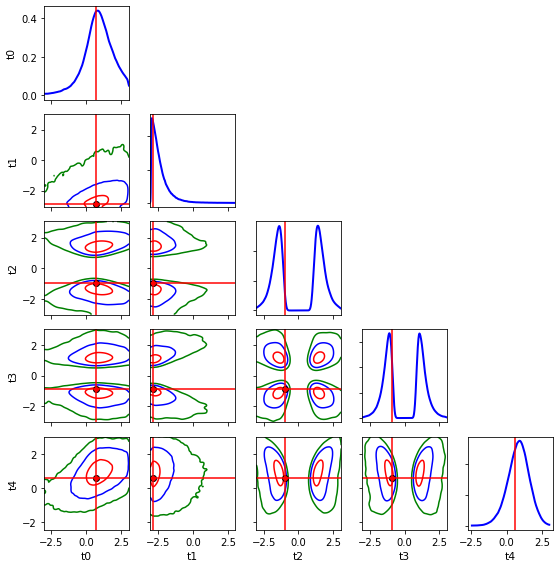

In [172]:
plot_params_kde(data_0, figsize=(8,8),limits=None,
  point_estimate=None, reference_values=truth, reference_color='r')#fname='./simple1_true_posterior.pdf');